# Import Libariers and Dataset Loading

In [ ]:
!pip install --upgrade supervision
!pip install ultralytics
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Polygon
import supervision as sv
import random
import shutil
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from tqdm import tqdm
import yaml
import cv2
from ultralytics import YOLO
import time 
from shapely.geometry import box

images_path = '/kaggle/input/srip-2025/image_chips_native-20250212T103727Z-001/image_chips_native'
labels_path = '/kaggle/input/srip-2025/labels-20250212T103318Z-001/labels/labels_native/'
label_files = glob.glob(os.path.join(labels_path, '*.txt'))

# Data Exploration and Understanding

#### 1. Dataset statistics 


In [ ]:
import os
import glob

# Define the labels directory and list all .txt label files
labels_path = '/kaggle/input/srip-2025/labels-20250212T103318Z-001/labels/labels_native/'
label_files = glob.glob(os.path.join(labels_path, '*.txt'))

# ------------------------------
# Step 1: Count initial class distribution
# ------------------------------
total_instances = 0
class_count = {}

for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        total_instances += len(lines)
        for line in lines:
            # Extract the class (first value)
            cls = line.split()[0]
            class_count[cls] = class_count.get(cls, 0) + 1

class_count = dict(sorted(class_count.items()))
print("Initial Distribution:")
print(f"Total instances: {total_instances}")
print(f"Number of unique classes: {len(class_count)}")
print("Class-wise distribution:")
for cls, count in class_count.items():
    print(f"    Class {cls}: {count}")

# ------------------------------
# Step 2: Convert classes 1 and 2 to 0 and remove duplicate lines
# ------------------------------
for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
    
    # Use a set to track unique lines after conversion
    unique_lines = set()
    new_lines = []
    
    for line in lines:
        parts = line.strip().split()
        # Skip malformed lines
        if len(parts) != 5:
            continue
        
        # Convert class "1" or "2" to "0"
        if parts[0] in ['1', '2']:
            parts[0] = '0'
        
        # Rebuild the line string
        new_line = ' '.join(parts)
        
        # Add only unique lines
        if new_line not in unique_lines:
            unique_lines.add(new_line)
            new_lines.append(new_line)
    
    # Write the updated unique lines back to the label file
    with open(label_file, 'w') as f:
        for line in new_lines:
            f.write(line + "\n")

# ------------------------------
# Step 3: Recount and display the updated class distribution
# ------------------------------
new_class_count = {}
for label_file in label_files:
    with open(label_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            cls = line.split()[0]
            new_class_count[cls] = new_class_count.get(cls, 0) + 1

new_class_count = dict(sorted(new_class_count.items()))
print("\nUpdated class-wise distribution:")
for cls, count in new_class_count.items():
    print(f"    Class {cls}: {count}")

In [2]:
def count_labels_in_file(label_file):
    """
    Count the number of solar panel instances in a label file.
    Each non-empty line represents one solar panel.
    """
    try:
        with open(label_file, 'r') as f:
            lines = f.readlines()
            return len([line for line in lines if line.strip()])
    except Exception as e:
        print(f"Error reading file {label_file}: {e}")
        return 0

# Process label files and collect data
data = []
for file in tqdm(label_files, desc="Processing label files"):
    # Derive the corresponding image name (assuming .tif extension)
    image_name = os.path.basename(file).replace('.txt', '.tif')
    label_count = count_labels_in_file(file)
    data.append({'Image': image_name, 'Label_Count': label_count})

# Create a DataFrame from the collected data
df_labels = pd.DataFrame(data)

# Calculate total number of solar panel instances
total_labels = df_labels['Label_Count'].sum()

# Calculate the distribution of label counts per image
value_counts = df_labels['Label_Count'].value_counts().sort_index()

# Calculate summary statistics
summary_stats = {
    'Total Images': len(df_labels),
    'Total Solar Panels': total_labels,
    'Average Panels per Image': total_labels / len(df_labels) if len(df_labels) > 0 else 0,
    'Max Panels in Single Image': df_labels['Label_Count'].max() if not df_labels.empty else 0,
    'Min Panels in Single Image': df_labels['Label_Count'].min() if not df_labels.empty else 0,
    'Images with No Panels': (df_labels['Label_Count'] == 0).sum()
}

# Sort DataFrame by label count in descending order for detailed view
detailed_counts = df_labels.sort_values('Label_Count', ascending=False)

Processing label files: 100%|██████████| 2542/2542 [00:22<00:00, 111.76it/s]


a. How many instances of solar panels are present in the dataset?
b. Compute and show the value counts of labels per image. E.g., X images have 0 labels, Y images have 1 label, … and so on.

In [3]:
print("\nDataset Summary Statistics:")
print("-" * 50)
for metric, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{metric}: {value:.2f}")
    else:
        print(f"{metric}: {value}")

print("\nDistribution of Panels per Image:")
print("-" * 50)
print(value_counts.to_string())

print("\nTop 5 Images with Most Panels:")
print("-" * 50)
print(detailed_counts.head().to_string(index=False))


Dataset Summary Statistics:
--------------------------------------------------
Total Images: 2542
Total Solar Panels: 29625
Average Panels per Image: 11.65
Max Panels in Single Image: 78
Min Panels in Single Image: 1
Images with No Panels: 0

Distribution of Panels per Image:
--------------------------------------------------
Label_Count
1      81
2     167
3     221
4     218
5     217
6     189
7     170
8     184
9     169
10    121
11     97
12     84
13     69
14     49
15     46
16     41
17     36
18     25
19     29
20     14
21      4
22      1
23      4
24      2
25      4
26      3
27      5
28      5
29     15
30     20
31      8
32      7
33     13
34     19
35     10
36      6
37     17
38     13
39      6
40      9
41     10
42     12
43     11
44      4
45      2
46      5
47      9
48      3
49      5
50      6
51      9
52     16
53      4
54      6
55      1
56      1
58      3
59      2
60      2
61      1
62      6
63      3
64      1
65      3
66      4
67      1

#### 2.  Calculate the statistics of the area of solar panels in meters (Read label readme carefully for this question)

a.What method was used to compute the area (in meters) for a single instance?
b.What is the mean area and standard deviation?
c.Plot the histogram of areas. What do you observe?

Using fixed image dimensions: 416x416 pixels


Calculating areas: 100%|██████████| 2542/2542 [00:01<00:00, 1788.60it/s]



Method Used to Compute Area:
--------------------------------------------------
For each solar panel instance:
1. Extract normalized x_width and y_width from label file.
2. Convert to pixels: width_pixels = normalized_width * image_width
3. Convert to meters: width_meters = width_pixels * 0.31
4. Area = x_width_meters * y_width_meters (in square meters)

Area Statistics:
--------------------------------------------------
Total Instances: 29625
Mean Area: 191.52 square meters
Standard Deviation: 630.70 square meters
Median Area: 91.68 square meters
Minimum Area: 1.06 square meters
Maximum Area: 12177.41 square meters


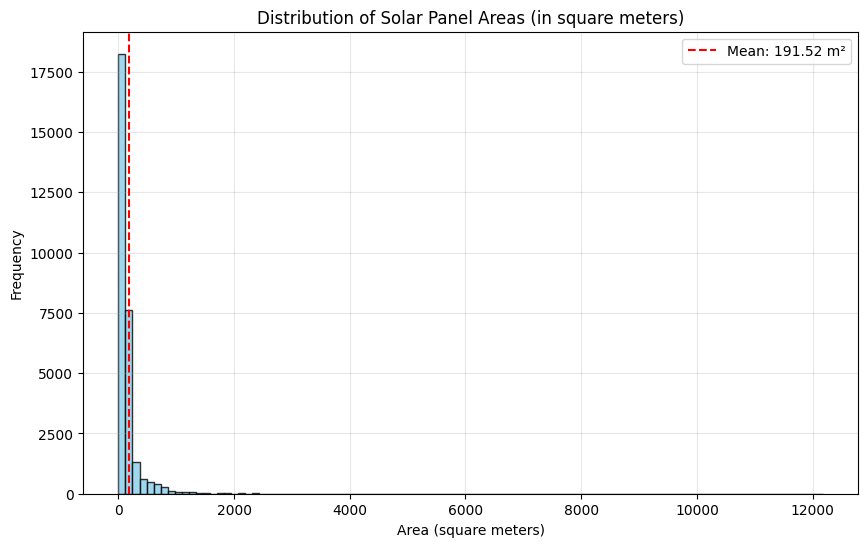


Observations from Histogram:
--------------------------------------------------
- The distribution peaks around 191.52 square meters.
- Spread is indicated by std dev of 630.70; higher values suggest variability.
- Check for skewness: right skew may indicate a few large panels, left skew small ones.
- Multiple peaks could suggest different panel sizes in the dataset.


In [4]:
PIXEL_SIZE = 0.31  # Meters per pixel, verify with your dataset documentation

# Function to calculate area in square meters from a single label line
def calculate_area_from_line(line, img_width, img_height):
    parts = line.strip().split()
    if len(parts) != 5:
        return None  # Skip malformed lines
    try:
        # Extract normalized width and height
        x_width_norm = float(parts[3])
        y_width_norm = float(parts[4])

        # Convert normalized to pixel dimensions
        x_width_pixels = x_width_norm * img_width
        y_width_pixels = y_width_norm * img_height

        # Convert pixel dimensions to meters
        x_width_meters = x_width_pixels * PIXEL_SIZE
        y_width_meters = y_width_pixels * PIXEL_SIZE

        # Calculate area in square meters
        return x_width_meters * y_width_meters
    except (ValueError, IndexError):
        return None  # Return None for invalid data

# Collect areas for all solar panel instances
areas = []
label_files = glob.glob(os.path.join(labels_path, '*.txt'))

# Assuming all images have the same size, get dimensions from one image
sample_image_path = os.path.join(images_path, os.listdir(images_path)[0])
with Image.open(sample_image_path) as img:
    img_width, img_height = img.size
print(f"Using fixed image dimensions: {img_width}x{img_height} pixels")

# Process all label files
for label_file in tqdm(label_files, desc="Calculating areas"):
    try:
        # Read label file (no need to open the image)
        with open(label_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line.strip():  # Skip empty lines
                    area = calculate_area_from_line(line, img_width, img_height)
                    if area is not None:
                        areas.append(area)
    except Exception as e:
        print(f"Error processing {label_file}: {e}")

# Convert areas to numpy array for calculations
areas = np.array(areas)

# Calculate statistics
total_instances = len(areas)
mean_area = np.mean(areas) if total_instances > 0 else 0
std_area = np.std(areas) if total_instances > 0 else 0
median_area = np.median(areas) if total_instances > 0 else 0
min_area = np.min(areas) if total_instances > 0 else 0
max_area = np.max(areas) if total_instances > 0 else 0

# Display method and statistics
print("\nMethod Used to Compute Area:")
print("-" * 50)
print("For each solar panel instance:")
print("1. Extract normalized x_width and y_width from label file.")
print("2. Convert to pixels: width_pixels = normalized_width * image_width")
print(f"3. Convert to meters: width_meters = width_pixels * {PIXEL_SIZE}")
print("4. Area = x_width_meters * y_width_meters (in square meters)")

print("\nArea Statistics:")
print("-" * 50)
print(f"Total Instances: {total_instances}")
print(f"Mean Area: {mean_area:.2f} square meters")
print(f"Standard Deviation: {std_area:.2f} square meters")
print(f"Median Area: {median_area:.2f} square meters")
print(f"Minimum Area: {min_area:.2f} square meters")
print(f"Maximum Area: {max_area:.2f} square meters")

# Plot histogram of areas
plt.figure(figsize=(10, 6))
plt.hist(areas, bins = 100, color='skyblue', edgecolor='black', alpha=0.8)
plt.title('Distribution of Solar Panel Areas (in square meters)')
plt.xlabel('Area (square meters)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.axvline(mean_area, color='r', linestyle='dashed', linewidth=1.5, label=f'Mean: {mean_area:.2f} m²')
plt.legend()
plt.show()

# Observations
print("\nObservations from Histogram:")
print("-" * 50)
if total_instances > 0:
    print(f"- The distribution peaks around {mean_area:.2f} square meters.")
    print(f"- Spread is indicated by std dev of {std_area:.2f}; higher values suggest variability.")
    print("- Check for skewness: right skew may indicate a few large panels, left skew small ones.")
    print("- Multiple peaks could suggest different panel sizes in the dataset.")
else:
    print("No valid areas calculated; check data integrity.")

# Implementing the Fundamental Functions


#### 1. Write a function to compute IoU (Intersection over Union) https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library [https://pypi.org/project/shapely/] and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library 

In [5]:
boxA = [35, 51,196, 110]
boxB = [25, 60,180, 120]

xA = max(boxA[0], boxB[0])
yA = max(boxA[1], boxB[1])
xB = min(boxA[2], boxB[2])
yB = min(boxA[3], boxB[3])

print(xA,yA,xB,yB)

interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

iou = interArea / float(boxAArea + boxBArea - interArea)

print(iou)

35 60 180 110
0.6315521628498728


NameError: name 'plot_polygon' is not defined

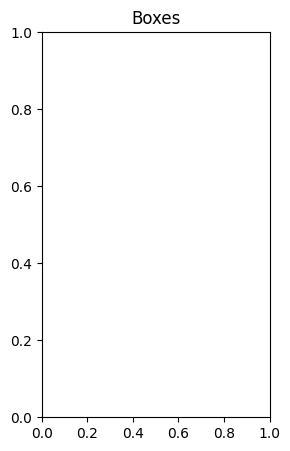

In [6]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
bA = box(35, 51,196, 110)
bB = box(25, 60,180, 120)

plt.figure(figsize=(10,5))

plt.subplot(1,3,1)
plt.title("Boxes")
plot_polygon(bB,color='g')
plot_polygon(bA,color='r')

plt.subplot(1,3,2)
plt.title("Intersection")
interArea = bA.intersection(bB)
plot_polygon(interArea,color='k')

plt.subplot(1,3,3)
plt.title("Union")
union = bA.union(bB)
plot_polygon(union)

In [7]:

def compIou(bA,bB):
  return bA.intersection(bB).area / bA.union(bB).area

bA = box(35, 51,196, 110)
bB = box(25, 60,180, 120)

compIou(bA,bB)

0.62775997921898

In [8]:
bA = [[35, 51,196, 110]]
bB = [[25, 60,180, 120]]
bA = np.asarray(bA)
bB = np.asarray(bB)
sv.box_iou_batch(bA,bB)

array([[    0.62776]])

#### 2. Write a function to compute Average Precision (AP) 

In [9]:
def getPreRec(gx,gy,px,py):
    IOU=[]
    for i in range(0,10):
        bA = box(gx[i],gy[i],gx[i]+20,gy[i]+20)
        bB = box(px[i],py[i],px[i]+20,py[i]+20)
        iou = bA.intersection(bB).area / bA.union(bB).area
        IOU.append(iou)

    tpfp = ["TP" if score >=0.5 else "FP" for score in IOU]

    sc = 0
    accTP = []
    for i in range(0,10):
        if tpfp[i]=="TP":
            sc+=1
        accTP.append(sc)

    sc =0
    accFP = []
    for i in range(0,10):
        if tpfp[i]=="FP":
            sc+=1
        accFP.append(sc)

    groundTruths = 10
    precision = []
    recall = []

    for i in range(0,10):
        precision.append(accTP[i]/(accTP[i]+accFP[i]))
        recall.append(accTP[i]/groundTruths)

    return precision,recall

a. Use Pascal VOC 11 point interpolation method to implement the function 

In [10]:
def point11(precision,recall):
    su = 0
    r = np.linspace(0,1,11)

    for i in r:
        valid = [p for p,r in zip(precision,recall) if r>=i]
        if valid:
            su+=max(valid)
        else:
            su+=0
    return su/11

b. Use COCO 101-point interpolation method to implement the function.

In [11]:
def point101(precision,recall):
    su = 0
    r = np.linspace(0,1,101)

    for i in r:
        valid = [p for p,r in zip(precision,recall) if r>=i]
        if valid:
            su+=max(valid)
        else:
            su+=0
    return su/101     

c. Use Area under Precision-Recall Curve (AP) method to implement the function 

In [12]:
def AUC(precision,recall,length):
    s=0
    for i in range(1,length):
        width = recall[i]-recall[i-1]
        height = max(precision[i],precision[i-1])
        s += width*height
    return s

d.Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods.

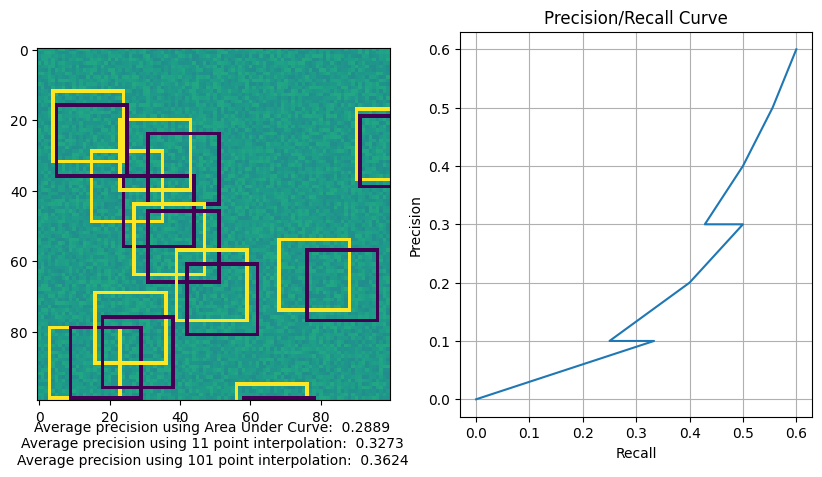

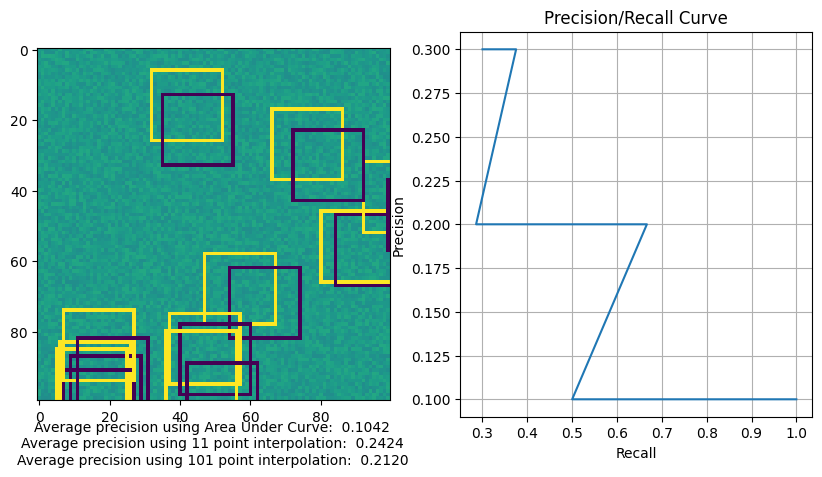

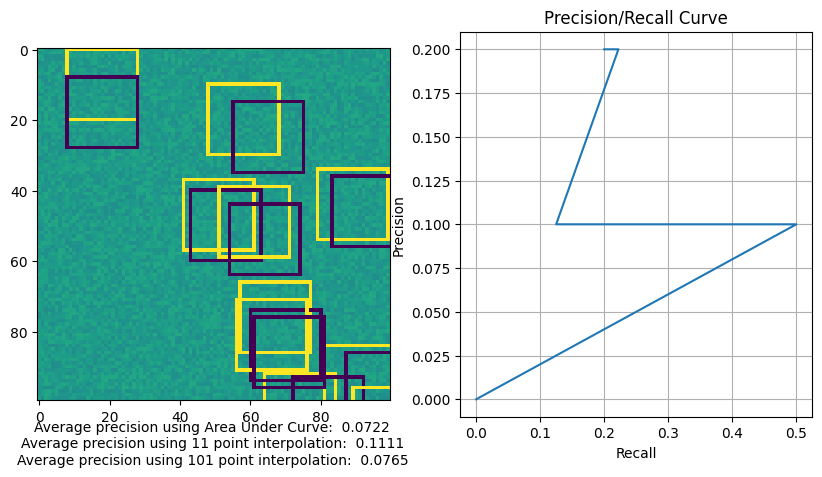

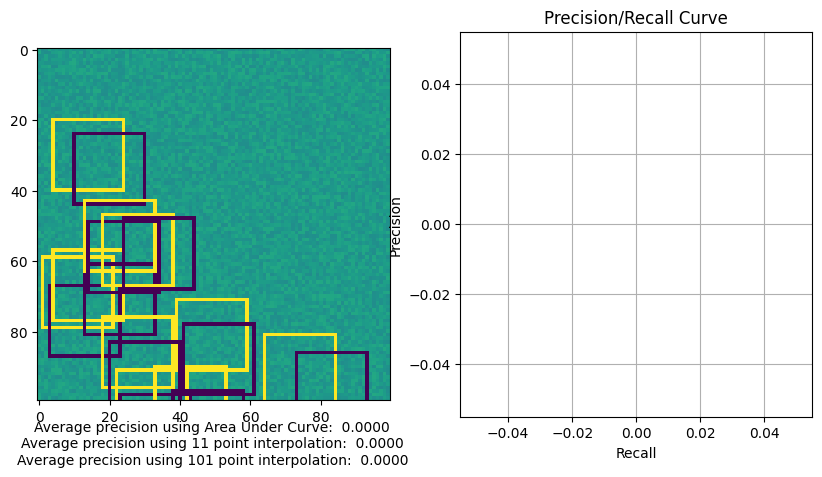

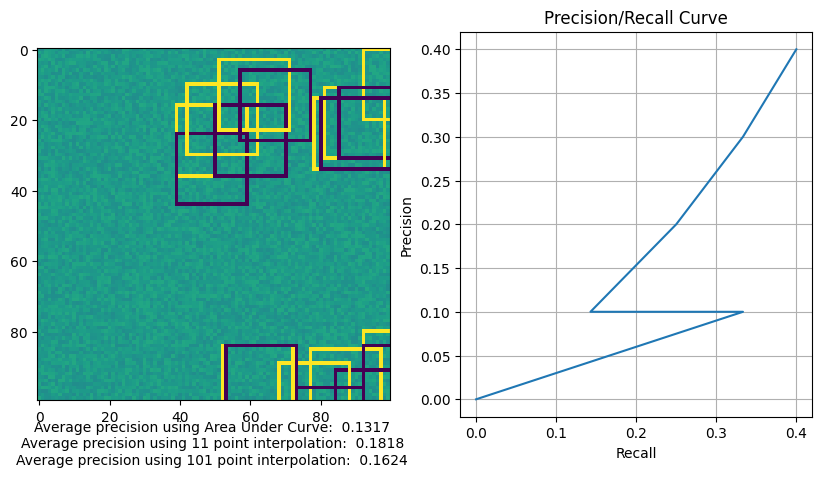

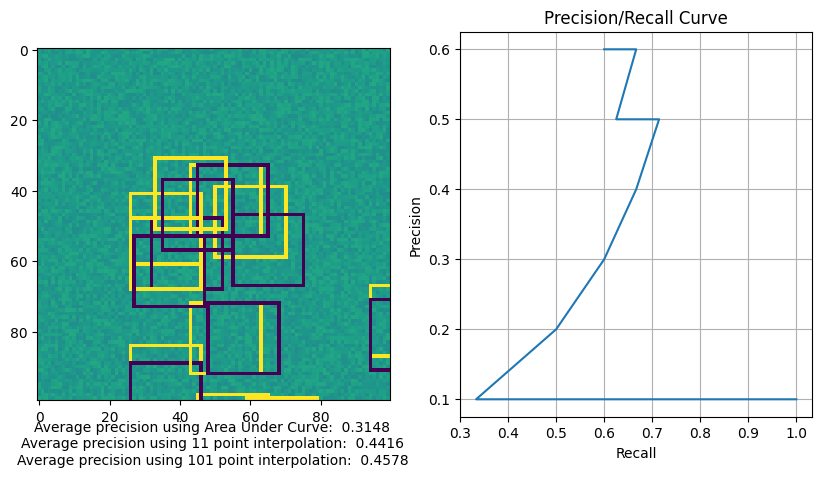

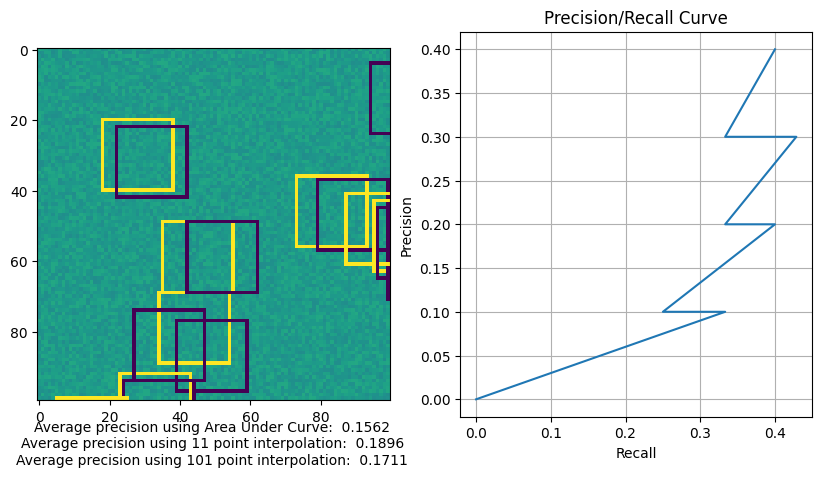

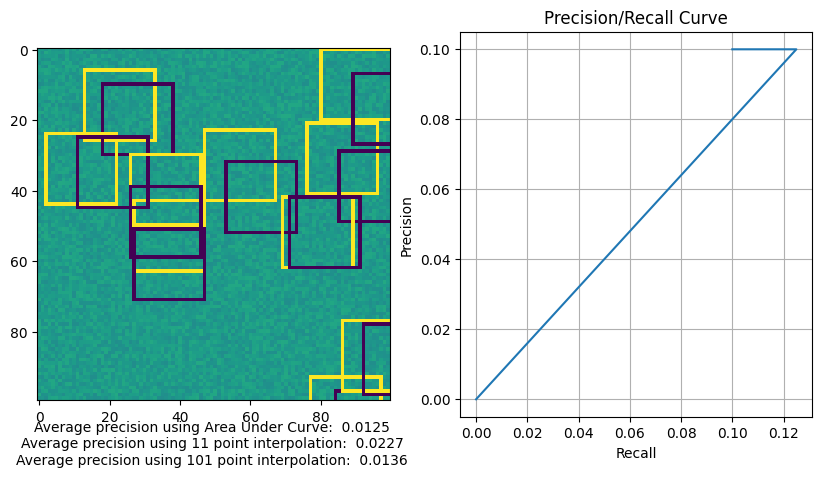

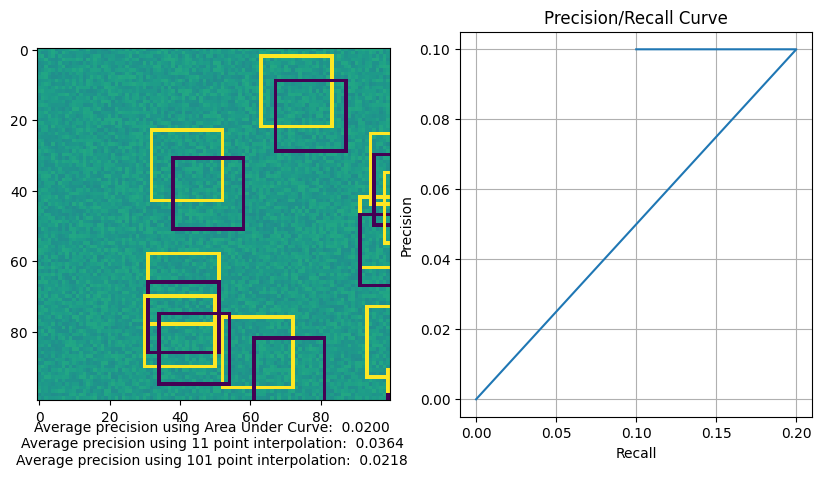

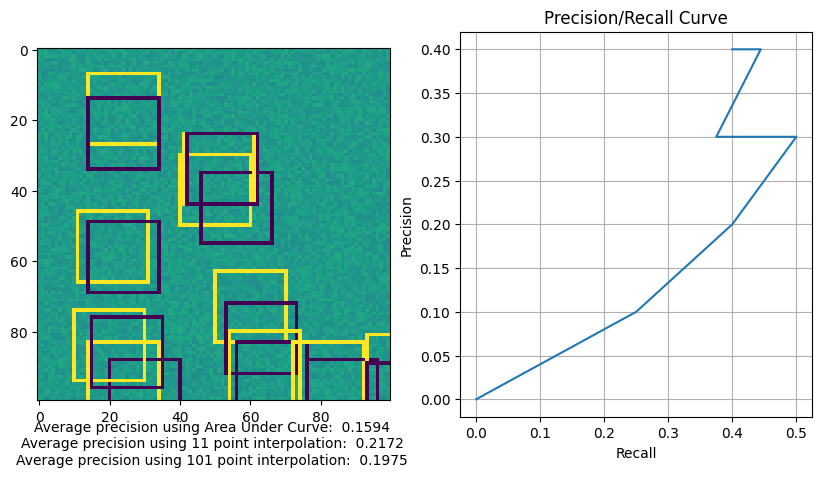

In [13]:
imgs = np.random.randint(125,155,size=(10,100,100)).astype(float)


# plt.figure(figsize=(20,10))
for i in range(0,10):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)


    gx = np.random.randint(0,100,size=(10))
    gy = np.random.randint(0,100,size=(10))

    px = np.random.randint(gx,gx+10,size=(10))
    py = np.random.randint(gy,gy+10,size=(10))

    precision,recall = getPreRec(gx,gy,px,py)



    for j in range(0,10):
        img = cv2.rectangle(imgs[i],(gx[j],gy[j]),(gx[j]+20,gy[j]+20),(255,0,0),1)
        img = cv2.rectangle(imgs[i],(px[j],py[j]),(px[j]+20,py[j]+20),(0,255,0),1)

    plt.imshow(img)

    plt.subplot(1,2,2)


    plt.plot(precision,recall)
    plt.grid()
    plt.title("Precision/Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.figtext(
        0.3, 0.02,
        f"Average precision using Area Under Curve:  {AUC(precision,recall,10):.4f}\nAverage precision using 11 point interpolation:  {point11(precision,recall):.4f}\nAverage precision using 101 point interpolation:  {point101(precision,recall):.4f}",
        wrap=True, horizontalalignment='center', fontsize=10 )

     

# Model building and evaluation 



#### 1.Split the data into 80-20 train-test split. Use 10% of training data as validation.
Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged. 

In [14]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Original dataset directories
images_path = '/kaggle/input/srip-2025/image_chips_native-20250212T103727Z-001/image_chips_native'
labels_path = '/kaggle/input/srip-2025/labels-20250212T103318Z-001/labels/labels_native/'

# Base directory for the copied dataset splits (use a working directory to avoid modifying original data)
base_dir = '/kaggle/working/srip_dataset_split'
train_img_dir = os.path.join(base_dir, 'train', 'images')
train_lbl_dir = os.path.join(base_dir, 'train', 'labels')
val_img_dir   = os.path.join(base_dir, 'val', 'images')
val_lbl_dir   = os.path.join(base_dir, 'val', 'labels')
test_img_dir  = os.path.join(base_dir, 'test', 'images')
test_lbl_dir  = os.path.join(base_dir, 'test', 'labels')

# Create directories if they don't already exist
for directory in [train_img_dir, train_lbl_dir, val_img_dir, val_lbl_dir, test_img_dir, test_lbl_dir]:
    os.makedirs(directory, exist_ok=True)

# List all image files in the original images directory
# (Assuming images are in any format; adjust the pattern if needed, e.g., '*.tif')
image_files = glob.glob(os.path.join(images_path, '*'))

# Split into 80% train and 20% test (randomly)
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)

# Further split training files into train and validation (10% of training data as validation)
train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

def copy_files(file_list, dest_img_dir, dest_lbl_dir):
    """
    Copy image files and their corresponding label files into destination directories.
    Assumes that for each image file, the corresponding label file has the same basename
    with '.txt' extension (replacing the image extension).
    """
    for file in tqdm(file_list, desc=f"Copying files to {dest_img_dir}"):
        # Copy the image file
        shutil.copy(file, dest_img_dir)
        
        # Derive the corresponding label file (assuming image extension '.tif')
        base_name = os.path.basename(file)
        label_file = os.path.join(labels_path, base_name.replace('.tif', '.txt'))
        if os.path.exists(label_file):
            shutil.copy(label_file, dest_lbl_dir)

# Copy files into their respective directories
copy_files(train_files, train_img_dir, train_lbl_dir)
copy_files(val_files, val_img_dir, val_lbl_dir)
copy_files(test_files, test_img_dir, test_lbl_dir)

print("Dataset splitting and copying completed!")

Copying files to /kaggle/working/srip_dataset_split/train/images: 100%|██████████| 1837/1837 [00:31<00:00, 58.21it/s]
Copying files to /kaggle/working/srip_dataset_split/val/images: 100%|██████████| 205/205 [00:03<00:00, 62.06it/s]
Copying files to /kaggle/working/srip_dataset_split/test/images: 100%|██████████| 511/511 [00:08<00:00, 59.86it/s]

Dataset splitting and copying completed!


In [15]:
import yaml

# Define the YAML configuration dictionary using the copied dataset directories
data_yaml = {
    "train": train_img_dir,  # Path to training images
    "val":val_img_dir ,      # Path to validation images
    "test":test_img_dir,    # (Optional) Path to test images
    "nc": 1,                 # Number of classes
    "names": ["solar_panel"] # List of class names
}

# Specify the path where the YAML file will be saved
yaml_path = os.path.join(base_dir, "data.yaml")

# Write the YAML file
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("YAML configuration file created at:", yaml_path)


YAML configuration file created at: /kaggle/working/srip_dataset_split/data.yaml


In [16]:
!pip install ultralytics
from ultralytics import YOLO

# Load a COCO-pretrained YOLO11n model
model_run1 = YOLO("yolo11l.pt")
# Train the model with hyperparameters for Experiment 1:
# - 50 epochs, batch size 16, initial learning rate 0.01, image size 416x416
results_run1 = model_run1.train(
    data='/kaggle/working/srip_dataset_split/data.yaml',
    epochs=30,
    imgsz=416,
    batch=16,
    lr0=0.01,
    project='/kaggle/working/srip_training/yolov11l',
    name='run1'
)

# Optionally, display the loss plot for run1
results_run1.plot_loss()


100%|██████████| 49.0M/49.0M [00:00<00:00, 275MB/s]


Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/srip_dataset_split/data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/srip_training/yolov11l, name=run1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

100%|██████████| 755k/755k [00:00<00:00, 18.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  2    173824  ultralytics.nn.modules.block.C3k2            [128, 256, 2, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  2    691712  ultralytics.nn.modules.block.C3k2            [256, 512, 2, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  2   2234368  ultralytics.nn.modules.block.C3k2            [512, 512, 2, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/srip_dataset_split/train/labels... 1830 images, 7 backgrounds, 165 corrupt: 100%|██████████| 1837/1837 [00:02<00:00, 697.50it/s]

train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_128_y0_7056_dxdy_416.tif: ign

train: New cache created: /kaggle/working/srip_dataset_split/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/srip_dataset_split/val/labels... 203 images, 2 backgrounds, 21 corrupt: 100%|██████████| 205/205 [00:00<00:00, 604.74it/s]

val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_1300_y0_10050_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_2309_y0_8071_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_368_y0_7395_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_7474_y0_9842_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_7604_y0_9799_dxdy_416.tif: ignoring c

Plotting labels to /kaggle/working/srip_training/yolov11l/run1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /kaggle/working/srip_training/yolov11l/run1
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      4.98G      1.708      1.395      1.315        119        416: 100%|██████████| 105/105 [00:39<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.91it/s]

                   all        184       2626       0.27      0.224     0.0923     0.0448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      4.83G      1.549      1.085       1.21        117        416: 100%|██████████| 105/105 [00:37<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all        184       2626      0.665      0.592      0.565      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      4.86G      1.524      1.035      1.202         83        416: 100%|██████████| 105/105 [00:38<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.91it/s]

                   all        184       2626      0.622      0.625      0.606      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      4.88G      1.495      1.005       1.19         38        416: 100%|██████████| 105/105 [00:38<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  3.00it/s]

                   all        184       2626      0.807      0.768      0.811      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       4.9G      1.406     0.9355      1.146         77        416: 100%|██████████| 105/105 [00:38<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.99it/s]

                   all        184       2626       0.78      0.712      0.761      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      4.94G      1.339     0.8545      1.119        134        416: 100%|██████████| 105/105 [00:38<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.94it/s]

                   all        184       2626      0.621      0.662      0.655      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      4.88G      1.334     0.8483      1.106        142        416: 100%|██████████| 105/105 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2626      0.853      0.804       0.87       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      4.91G       1.32      0.839      1.095        121        416: 100%|██████████| 105/105 [00:38<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2626      0.862      0.808      0.881      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      4.81G      1.264     0.7965      1.071        182        416: 100%|██████████| 105/105 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2626      0.864      0.834      0.895      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      4.92G      1.218     0.7644      1.055        120        416: 100%|██████████| 105/105 [00:38<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  3.00it/s]

                   all        184       2626      0.855      0.788       0.86      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      4.88G       1.21     0.7438      1.047        119        416: 100%|██████████| 105/105 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.05it/s]

                   all        184       2626       0.86      0.822      0.883      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      4.95G      1.164     0.7387      1.038        198        416: 100%|██████████| 105/105 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all        184       2626       0.91      0.819      0.905       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      4.87G      1.157     0.7125      1.032        119        416: 100%|██████████| 105/105 [00:38<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all        184       2626       0.89      0.793      0.896      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      4.94G      1.152     0.7078      1.022        133        416: 100%|██████████| 105/105 [00:38<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]

                   all        184       2626      0.907      0.842      0.922      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      4.85G      1.099     0.6796      1.011         73        416: 100%|██████████| 105/105 [00:38<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

                   all        184       2626      0.906      0.865      0.924      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      4.92G      1.095     0.6631      1.005        193        416: 100%|██████████| 105/105 [00:38<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

                   all        184       2626      0.894      0.854      0.922      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      4.91G      1.088     0.6563      0.996        101        416: 100%|██████████| 105/105 [00:38<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.04it/s]

                   all        184       2626      0.801      0.806      0.853      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      4.94G      1.076     0.6451     0.9845         69        416: 100%|██████████| 105/105 [00:38<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]

                   all        184       2626      0.892      0.865       0.93      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      4.85G      1.038     0.6124     0.9849        127        416: 100%|██████████| 105/105 [00:38<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

                   all        184       2626      0.929      0.869      0.942      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      4.94G      1.029     0.6065     0.9776        105        416: 100%|██████████| 105/105 [00:38<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

                   all        184       2626      0.879      0.862      0.917      0.671


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      4.87G     0.9901     0.5923     0.9764         50        416: 100%|██████████| 105/105 [00:38<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

                   all        184       2626      0.909      0.908      0.943      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      4.92G     0.9565     0.5664     0.9604         72        416: 100%|██████████| 105/105 [00:37<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.11it/s]

                   all        184       2626      0.935      0.891      0.948      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      4.82G     0.9464     0.5547     0.9697         70        416: 100%|██████████| 105/105 [00:37<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

                   all        184       2626      0.926      0.893      0.945      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      4.92G     0.9384      0.542     0.9519         64        416: 100%|██████████| 105/105 [00:37<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

                   all        184       2626       0.93       0.89      0.949      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      4.91G     0.9199     0.5274     0.9483         97        416: 100%|██████████| 105/105 [00:37<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

                   all        184       2626      0.927        0.9      0.952      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      4.87G     0.9017     0.5141     0.9401        140        416: 100%|██████████| 105/105 [00:38<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.13it/s]

                   all        184       2626      0.938      0.912       0.96      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      4.82G     0.8862     0.5027     0.9401         93        416: 100%|██████████| 105/105 [00:37<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

                   all        184       2626      0.947      0.918      0.961      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      4.93G     0.8575     0.4853     0.9266        106        416: 100%|██████████| 105/105 [00:37<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]

                   all        184       2626      0.947      0.917      0.962       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      4.91G     0.8428     0.4807     0.9197         46        416: 100%|██████████| 105/105 [00:37<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.12it/s]

                   all        184       2626      0.957       0.91      0.961      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      4.93G     0.8316     0.4703     0.9172         42        416: 100%|██████████| 105/105 [00:37<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]

                   all        184       2626      0.961      0.914      0.963      0.759



30 epochs completed in 0.353 hours.
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run1/weights/last.pt, 51.2MB
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run1/weights/best.pt, 51.2MB

Validating /kaggle/working/srip_training/yolov11l/run1/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]


                   all        184       2626      0.961      0.914      0.963      0.759


Speed: 0.1ms preprocess, 6.5ms inference, 0.0ms loss, 6.5ms postprocess per image
Results saved to /kaggle/working/srip_training/yolov11l/run1


AttributeError: 'DetMetrics' object has no attribute 'plot_loss'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (dict of str): A dict of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    

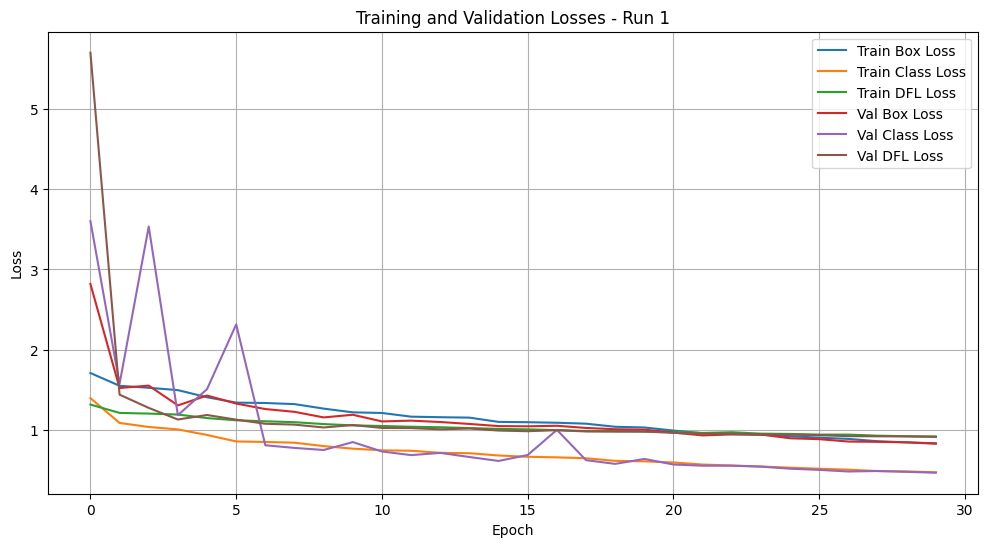

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the training results from the CSV file
results_path = '/kaggle/working/srip_training/yolov11l/run1/results.csv'
results_df = pd.read_csv(results_path)

# Strip any whitespace from column names (common issue with Ultralytics CSV files)
results_df.columns = results_df.columns.str.strip()

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(results_df['train/box_loss'], label='Train Box Loss')
plt.plot(results_df['train/cls_loss'], label='Train Class Loss')
plt.plot(results_df['train/dfl_loss'], label='Train DFL Loss')  # Distribution Focal Loss (if available)
plt.plot(results_df['val/box_loss'], label='Val Box Loss')
plt.plot(results_df['val/cls_loss'], label='Val Class Loss')
plt.plot(results_df['val/dfl_loss'], label='Val DFL Loss')      # If available
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses - Run 1')
plt.legend()
plt.grid(True)
plt.show()

####  model 2

In [18]:
model_run2 = YOLO('yolo11l.pt')
results_run2 = model_run2.train(
    data='/kaggle/working/srip_dataset_split/data.yaml',
    epochs=70,
    imgsz=416,
    batch=32,
    lr0=0.005,
    project='/kaggle/working/srip_training/yolov11l',
    name='run2'
)

Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/srip_dataset_split/data.yaml, epochs=70, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/srip_training/yolov11l, name=run2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=

train: Scanning /kaggle/working/srip_dataset_split/train/labels.cache... 1830 images, 7 backgrounds, 165 corrupt: 100%|██████████| 1837/1837 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_128_y0_7056_dxdy_416.tif: ign


val: Scanning /kaggle/working/srip_dataset_split/val/labels.cache... 203 images, 2 backgrounds, 21 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_1300_y0_10050_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_2309_y0_8071_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_368_y0_7395_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_7474_y0_9842_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_7604_y0_9799_dxdy_416.tif: ignoring c

Plotting labels to /kaggle/working/srip_training/yolov11l/run2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /kaggle/working/srip_training/yolov11l/run2
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      9.34G       1.92      1.689      1.431        139        416: 100%|██████████| 53/53 [00:40<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

                   all        184       2626     0.0265      0.293     0.0163    0.00677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      9.17G      1.552      1.067      1.218        163        416: 100%|██████████| 53/53 [00:38<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]

                   all        184       2626          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70         9G      1.484      1.013      1.174        109        416: 100%|██████████| 53/53 [00:38<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]

                   all        184       2626       0.14      0.108     0.0505     0.0284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      9.45G      1.501      1.002      1.181         77        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.43it/s]

                   all        184       2626      0.762      0.605      0.676      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      9.21G      1.389     0.9322      1.141        200        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]

                   all        184       2626      0.814        0.7       0.79      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      8.94G      1.345     0.8659      1.104        127        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]

                   all        184       2626      0.783      0.674      0.715      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      9.03G      1.293     0.8324      1.083        150        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]

                   all        184       2626      0.808      0.764      0.808      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      9.09G      1.242     0.8134      1.076        122        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all        184       2626      0.837      0.802      0.851      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      9.07G      1.272      0.813      1.074        176        416: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all        184       2626      0.789      0.702      0.754      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70       9.1G      1.242     0.7885      1.066         60        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

                   all        184       2626      0.835      0.745      0.815      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      9.15G      1.244     0.7804      1.074        104        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.47it/s]

                   all        184       2626      0.801      0.765      0.828      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      9.43G      1.201     0.7466      1.044        187        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all        184       2626      0.884      0.786       0.88      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      9.05G      1.205     0.7502      1.045         66        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.67it/s]

                   all        184       2626       0.74      0.404      0.427      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      9.09G      1.194     0.7359      1.043        154        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

                   all        184       2626      0.835       0.78      0.837      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      9.13G      1.161     0.7111      1.023        140        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all        184       2626      0.847        0.8      0.869      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      9.02G      1.121     0.6818      1.008        183        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

                   all        184       2626      0.818      0.799       0.85      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      9.05G      1.108     0.6752          1        126        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]

                   all        184       2626       0.89      0.844      0.903      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      9.18G      1.101      0.667     0.9998         70        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]

                   all        184       2626      0.831      0.799       0.86      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      9.08G      1.064     0.6486     0.9911        172        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all        184       2626      0.874      0.823      0.907       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      9.06G      1.094     0.6583     0.9945         80        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.49it/s]

                   all        184       2626      0.897      0.849       0.92       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      9.17G       1.07     0.6464     0.9825        280        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all        184       2626      0.864      0.862      0.916      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      9.17G      1.054     0.6385      0.985        177        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all        184       2626      0.904      0.882      0.926      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      9.26G      1.046     0.6324     0.9856        100        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.888      0.862      0.921      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      9.26G      1.024     0.6141       0.97        136        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.923      0.883       0.94      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      9.09G      1.035     0.6172     0.9814        129        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.887      0.877      0.927      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      9.22G      1.036      0.612     0.9788        172        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.912       0.85       0.92       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      9.08G      1.003     0.5908     0.9672        122        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all        184       2626      0.908      0.898      0.945      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      9.14G     0.9984     0.5951     0.9667        140        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all        184       2626      0.926      0.882      0.938      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      9.06G     0.9854     0.5856     0.9634        161        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all        184       2626      0.931      0.893       0.95      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      9.39G     0.9871     0.5824     0.9579         79        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all        184       2626      0.892        0.9      0.935      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      9.17G     0.9554     0.5628     0.9523        116        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all        184       2626      0.912      0.892      0.941        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      9.13G      0.974     0.5763     0.9557        156        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all        184       2626      0.934      0.894      0.946      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      9.13G     0.9288     0.5446     0.9473        112        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.934      0.887      0.946      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      9.14G     0.9443     0.5561     0.9404         90        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        184       2626      0.926      0.907      0.951      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      9.13G     0.9374     0.5441     0.9464         97        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.932      0.889      0.945      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      9.17G     0.9244     0.5443     0.9414         65        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        184       2626      0.926      0.912      0.949      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      9.15G     0.9069     0.5308     0.9321        121        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.927      0.912      0.954      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      8.95G      0.915     0.5342     0.9289        121        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626       0.93      0.919      0.958      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      9.09G     0.9032     0.5295     0.9358        191        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all        184       2626      0.921      0.908       0.95      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      9.15G     0.8981     0.5263     0.9314         74        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.928      0.908      0.952      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      9.22G     0.9019     0.5266     0.9305        133        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.935      0.914      0.954      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      9.12G     0.8795     0.5138     0.9187        120        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        184       2626      0.944      0.903       0.96       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70       9.2G     0.8813     0.5141     0.9228        108        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]

                   all        184       2626      0.939      0.906      0.955      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      9.37G     0.8655     0.5049     0.9187         88        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.947      0.918      0.958      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      9.12G     0.8572     0.5005     0.9167        188        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626       0.95      0.922      0.963      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      9.03G     0.8428     0.4897     0.9142        106        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        184       2626      0.943      0.924      0.962      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      9.25G     0.8436      0.492     0.9198        229        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.938      0.931      0.963      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70       9.3G     0.8453     0.4931     0.9189         72        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.939      0.925      0.962      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      9.33G     0.8365     0.4921     0.9148        217        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.948       0.92      0.962      0.762



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      9.07G     0.8122     0.4747     0.9088        164        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        184       2626      0.951      0.927      0.969      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      9.07G     0.8109     0.4726     0.9057        153        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.948      0.925      0.966      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      9.33G     0.8123     0.4727     0.9022        143        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.953      0.931      0.966      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      9.07G      0.799     0.4674     0.9055        140        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.959      0.926      0.968      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      9.09G     0.7992     0.4682     0.9054        122        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        184       2626      0.956      0.932      0.969      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      9.14G     0.7751      0.451     0.8951        165        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626       0.95      0.935      0.966      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      9.21G     0.7632     0.4464     0.9035        131        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626       0.95      0.929      0.965      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      9.12G     0.7665     0.4498     0.9006        179        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.957       0.94       0.97      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      9.17G     0.7659     0.4501     0.8975        122        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        184       2626      0.956      0.945       0.97      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      9.09G     0.7863     0.4583     0.9016         67        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        184       2626      0.956      0.934      0.971      0.798



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70       9.1G     0.7429     0.4397     0.8873        114        416: 100%|██████████| 53/53 [00:37<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.952      0.932      0.967      0.793


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      9.08G     0.7003     0.4113     0.8788        117        416: 100%|██████████| 53/53 [00:37<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.964      0.937      0.969      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      8.86G     0.6863     0.4034     0.8791         62        416: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.958      0.942      0.971      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70         9G     0.6685     0.3905     0.8722         60        416: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.958      0.948      0.971      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      8.91G     0.6644     0.3934     0.8699         89        416: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.961      0.948      0.974      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70         9G     0.6606     0.3859     0.8689         47        416: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        184       2626      0.964      0.947      0.973      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      8.91G     0.6454     0.3801     0.8694        125        416: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.967      0.946      0.972      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      9.13G     0.6396     0.3787     0.8663        101        416: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]

                   all        184       2626      0.964      0.949      0.973      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      8.95G     0.6232     0.3673     0.8613         52        416: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.957      0.952      0.972      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      9.07G     0.6196     0.3672      0.862        106        416: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]

                   all        184       2626      0.967      0.946      0.973       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      8.89G     0.6073      0.359      0.859         40        416: 100%|██████████| 53/53 [00:37<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all        184       2626      0.966      0.949      0.974      0.825



70 epochs completed in 0.809 hours.
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run2/weights/last.pt, 51.2MB
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run2/weights/best.pt, 51.2MB

Validating /kaggle/working/srip_training/yolov11l/run2/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.21s/it]


                   all        184       2626      0.967      0.949      0.974      0.825


Speed: 0.1ms preprocess, 6.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /kaggle/working/srip_training/yolov11l/run2


####  model 3

In [19]:
model_run3 = YOLO('yolo11l.pt')
results_run3 = model_run3.train(
    data='/kaggle/working/srip_dataset_split/data.yaml',
    epochs=50,
    imgsz=416,
    batch=8,
    lr0=0.02,
    project='/kaggle/working/srip_training/yolov11l',
    name='run3'
)

Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11l.pt, data=/kaggle/working/srip_dataset_split/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=8, project=/kaggle/working/srip_training/yolov11l, name=run3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=F

train: Scanning /kaggle/working/srip_dataset_split/train/labels.cache... 1830 images, 7 backgrounds, 165 corrupt: 100%|██████████| 1837/1837 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_6963_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_7119_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_7229_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_0_y0_7230_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /kaggle/working/srip_dataset_split/train/images/solarpanels_native_1__x0_128_y0_7056_dxdy_416.tif: ign


val: Scanning /kaggle/working/srip_dataset_split/val/labels.cache... 203 images, 2 backgrounds, 21 corrupt: 100%|██████████| 205/205 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_1300_y0_10050_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_2309_y0_8071_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_368_y0_7395_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_7474_y0_9842_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /kaggle/working/srip_dataset_split/val/images/solarpanels_native_1__x0_7604_y0_9799_dxdy_416.tif: ignoring c

Plotting labels to /kaggle/working/srip_training/yolov11l/run3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.02' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /kaggle/working/srip_training/yolov11l/run3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.58G      1.716      1.382        1.3        143        416: 100%|██████████| 209/209 [00:47<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]

                   all        184       2626      0.657      0.603      0.555      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.47G      1.639      1.169      1.252        195        416: 100%|██████████| 209/209 [00:43<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.98it/s]

                   all        184       2626      0.677      0.644      0.644      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.46G      1.607      1.119      1.245        107        416: 100%|██████████| 209/209 [00:42<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.91it/s]

                   all        184       2626      0.767       0.66      0.714      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.43G      1.523       1.06       1.21         70        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.06it/s]

                   all        184       2626      0.813       0.65      0.724      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.42G      1.455     0.9782      1.177        154        416: 100%|██████████| 209/209 [00:41<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.02it/s]

                   all        184       2626      0.785      0.749      0.788      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.46G      1.389     0.9118      1.142         93        416: 100%|██████████| 209/209 [00:41<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.04it/s]

                   all        184       2626       0.83      0.789      0.844      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.46G      1.366     0.8722      1.136        112        416: 100%|██████████| 209/209 [00:41<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.14it/s]

                   all        184       2626      0.884      0.786      0.875       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.43G      1.309     0.8512      1.119        118        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.18it/s]

                   all        184       2626      0.856      0.796      0.868      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.44G      1.343     0.8625      1.122        119        416: 100%|██████████| 209/209 [00:42<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.17it/s]

                   all        184       2626      0.849      0.812       0.87      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.42G      1.298       0.83      1.095        154        416: 100%|██████████| 209/209 [00:41<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.16it/s]

                   all        184       2626      0.875      0.796      0.868      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.43G      1.257     0.7783       1.08         85        416: 100%|██████████| 209/209 [00:42<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.19it/s]

                   all        184       2626      0.891      0.797      0.873      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.45G      1.221     0.7697       1.06        246        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.14it/s]

                   all        184       2626      0.882      0.822      0.893      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.43G      1.217     0.7559      1.069        157        416: 100%|██████████| 209/209 [00:41<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.11it/s]

                   all        184       2626      0.836      0.792      0.863      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.43G      1.221     0.7506      1.067        127        416: 100%|██████████| 209/209 [00:41<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.14it/s]

                   all        184       2626      0.884      0.803      0.892      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.46G      1.195     0.7427      1.048         91        416: 100%|██████████| 209/209 [00:41<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.18it/s]

                   all        184       2626      0.877      0.841      0.907       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.44G      1.173     0.7329      1.043        174        416: 100%|██████████| 209/209 [00:42<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.22it/s]

                   all        184       2626        0.9      0.834      0.915      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.43G      1.171     0.7205      1.039        201        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]

                   all        184       2626      0.879      0.851      0.915      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.43G       1.16     0.7283      1.038        108        416: 100%|██████████| 209/209 [00:42<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.16it/s]

                   all        184       2626      0.874      0.841      0.898      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.44G      1.127     0.6871      1.018        104        416: 100%|██████████| 209/209 [00:41<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]

                   all        184       2626      0.913      0.867      0.933      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.43G      1.123     0.6852      1.019        100        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.21it/s]

                   all        184       2626      0.899      0.824      0.916       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.44G      1.103     0.6708      1.011        230        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]

                   all        184       2626      0.903      0.869       0.93      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.46G      1.098     0.6635      1.011        100        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.95it/s]

                   all        184       2626      0.909      0.853      0.928      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.44G      1.081     0.6478      1.005         88        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.25it/s]

                   all        184       2626      0.909      0.871      0.936       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.46G      1.082     0.6431     0.9966         71        416: 100%|██████████| 209/209 [00:42<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]

                   all        184       2626      0.897      0.883      0.939      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.43G      1.078     0.6489          1        111        416: 100%|██████████| 209/209 [00:42<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]

                   all        184       2626      0.903      0.874      0.933       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.45G       1.06     0.6297     0.9926        163        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]

                   all        184       2626      0.927      0.873      0.941      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.45G      1.051     0.6205     0.9817        112        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.21it/s]

                   all        184       2626      0.917      0.894      0.945      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.46G      1.047     0.6158     0.9907        193        416: 100%|██████████| 209/209 [00:41<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.22it/s]

                   all        184       2626       0.93      0.869      0.941      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.42G      1.022     0.6082     0.9801        162        416: 100%|██████████| 209/209 [00:42<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:02<00:00,  5.93it/s]

                   all        184       2626      0.903      0.887       0.94      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.43G      1.012     0.6019     0.9777        100        416: 100%|██████████| 209/209 [00:41<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.21it/s]

                   all        184       2626      0.903      0.907      0.945      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.44G      1.021     0.6025     0.9847        124        416: 100%|██████████| 209/209 [00:41<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

                   all        184       2626      0.936      0.903      0.953       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.46G     0.9854     0.5845     0.9717        185        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.25it/s]

                   all        184       2626      0.929      0.897       0.95      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.43G     0.9765     0.5689      0.961         57        416: 100%|██████████| 209/209 [00:41<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

                   all        184       2626      0.939      0.896      0.953      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.44G     0.9652     0.5603     0.9548         94        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.25it/s]

                   all        184       2626      0.934      0.912      0.955      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.43G     0.9559     0.5615     0.9588        131        416: 100%|██████████| 209/209 [00:41<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.19it/s]

                   all        184       2626      0.944      0.906       0.96      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.38G     0.9459     0.5511     0.9506         95        416: 100%|██████████| 209/209 [00:42<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]

                   all        184       2626      0.941      0.904      0.956      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.47G     0.9355     0.5502     0.9584         76        416: 100%|██████████| 209/209 [00:41<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.23it/s]

                   all        184       2626      0.934      0.909      0.959      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.46G     0.9344      0.542     0.9456         76        416: 100%|██████████| 209/209 [00:41<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

                   all        184       2626      0.942      0.911      0.962      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.47G     0.9046     0.5278     0.9432        211        416: 100%|██████████| 209/209 [00:41<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.28it/s]

                   all        184       2626      0.944      0.917      0.961      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.44G     0.8941     0.5245     0.9384        106        416: 100%|██████████| 209/209 [00:41<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

                   all        184       2626      0.951      0.917      0.962      0.749


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      3.44G     0.8728     0.5008     0.9353        113        416: 100%|██████████| 209/209 [00:42<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.24it/s]

                   all        184       2626      0.943      0.924      0.962      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      3.43G     0.8565     0.4901     0.9306         75        416: 100%|██████████| 209/209 [00:41<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

                   all        184       2626      0.938      0.919      0.961       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      3.44G     0.8427     0.4789     0.9258        100        416: 100%|██████████| 209/209 [00:42<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.22it/s]

                   all        184       2626       0.95      0.927      0.963      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      3.41G     0.8248     0.4692     0.9165        101        416: 100%|██████████| 209/209 [00:41<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]

                   all        184       2626      0.953       0.92      0.964      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      3.43G     0.8182     0.4646      0.916         76        416: 100%|██████████| 209/209 [00:41<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

                   all        184       2626      0.952      0.922      0.966      0.769



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      3.44G     0.8073     0.4552     0.9111        112        416: 100%|██████████| 209/209 [00:41<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]

                   all        184       2626      0.947      0.932      0.967      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      3.47G     0.8018     0.4562     0.9058         52        416: 100%|██████████| 209/209 [00:41<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.28it/s]

                   all        184       2626      0.959      0.928      0.966      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      3.43G     0.7972      0.454     0.9128         52        416: 100%|██████████| 209/209 [00:41<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.27it/s]

                   all        184       2626      0.954      0.935      0.967      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.42G     0.7858     0.4458     0.9062         33        416: 100%|██████████| 209/209 [00:41<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.26it/s]

                   all        184       2626      0.957      0.925      0.967      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      3.43G     0.7746     0.4389     0.9012        103        416: 100%|██████████| 209/209 [00:42<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:01<00:00,  6.13it/s]

                   all        184       2626       0.96      0.923      0.967      0.784



50 epochs completed in 0.639 hours.
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run3/weights/last.pt, 51.2MB
Optimizer stripped from /kaggle/working/srip_training/yolov11l/run3/weights/best.pt, 51.2MB

Validating /kaggle/working/srip_training/yolov11l/run3/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11l summary (fused): 190 layers, 25,280,083 parameters, 0 gradients, 86.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 12/12 [00:03<00:00,  3.04it/s]


                   all        184       2626       0.96      0.923      0.968      0.784


Speed: 0.1ms preprocess, 6.0ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /kaggle/working/srip_training/yolov11l/run3


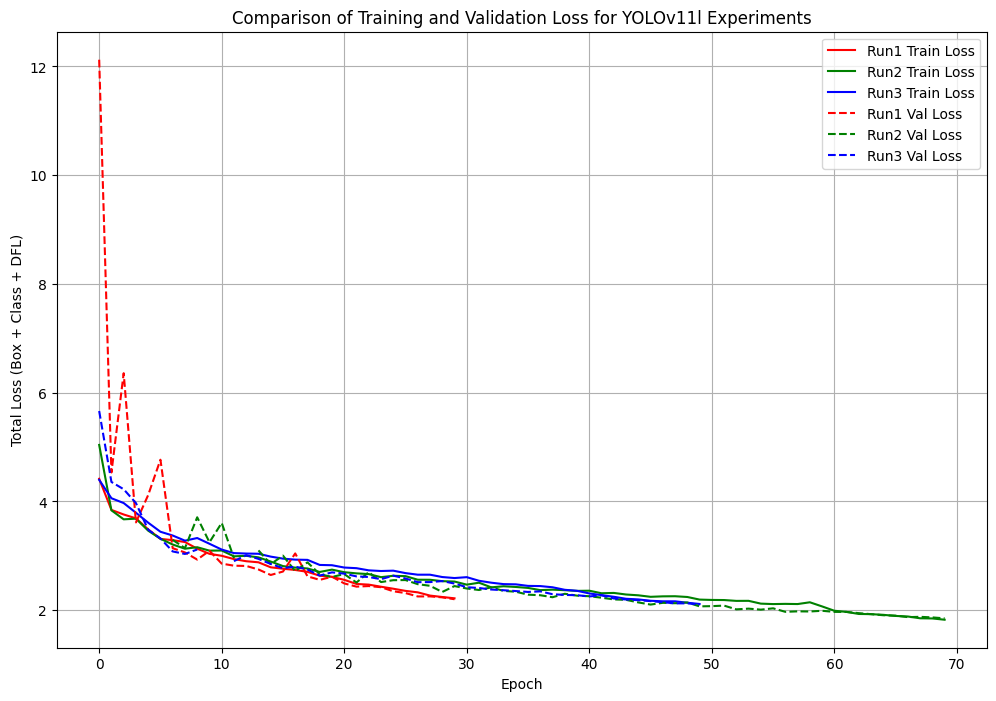

In [20]:
results_path1 = '/kaggle/working/srip_training/yolov11l/run1/results.csv'  # From your previous run1
results_path2 = '/kaggle/working/srip_training/yolov11l/run2/results.csv'
results_path3 = '/kaggle/working/srip_training/yolov11l/run3/results.csv'

history1 = pd.read_csv(results_path1)
history2 = pd.read_csv(results_path2)
history3 = pd.read_csv(results_path3)

# Strip whitespace from column names
history1.columns = history1.columns.str.strip()
history2.columns = history2.columns.str.strip()
history3.columns = history3.columns.str.strip()

# --- Create a combined plot ---
plt.figure(figsize=(12, 8))

# Plot training loss curves (solid lines)
plt.plot(history1['train/box_loss'] + history1['train/cls_loss'] + history1['train/dfl_loss'], 
         label='Run1 Train Loss', color='red')
plt.plot(history2['train/box_loss'] + history2['train/cls_loss'] + history2['train/dfl_loss'], 
         label='Run2 Train Loss', color='green')
plt.plot(history3['train/box_loss'] + history3['train/cls_loss'] + history3['train/dfl_loss'], 
         label='Run3 Train Loss', color='blue')

# Plot validation loss curves (dashed lines)
plt.plot(history1['val/box_loss'] + history1['val/cls_loss'] + history1['val/dfl_loss'], 
         label='Run1 Val Loss', color='red', linestyle='dashed')
plt.plot(history2['val/box_loss'] + history2['val/cls_loss'] + history2['val/dfl_loss'], 
         label='Run2 Val Loss', color='green', linestyle='dashed')
plt.plot(history3['val/box_loss'] + history3['val/cls_loss'] + history3['val/dfl_loss'], 
         label='Run3 Val Loss', color='blue', linestyle='dashed')

plt.xlabel('Epoch')
plt.ylabel('Total Loss (Box + Class + DFL)')
plt.title('Comparison of Training and Validation Loss for YOLOv11l Experiments')
plt.legend()
plt.grid(True)
plt.show()

#### 2.Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels. 


image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_1__x0_8357_y0_13087_dxdy_416.tif: 416x416 4 solar_panels, 28.0ms
Speed: 0.8ms preprocess, 28.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


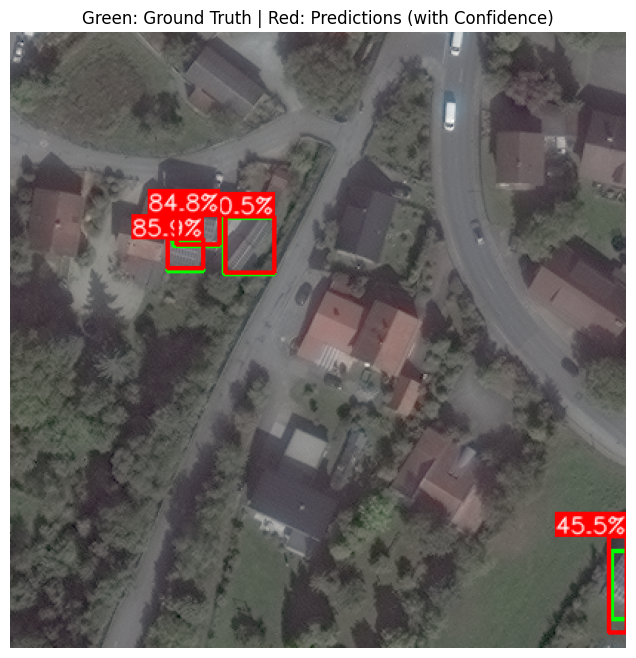


image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_2__x0_11252_y0_8109_dxdy_416.tif: 416x416 5 solar_panels, 28.1ms
Speed: 1.0ms preprocess, 28.1ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


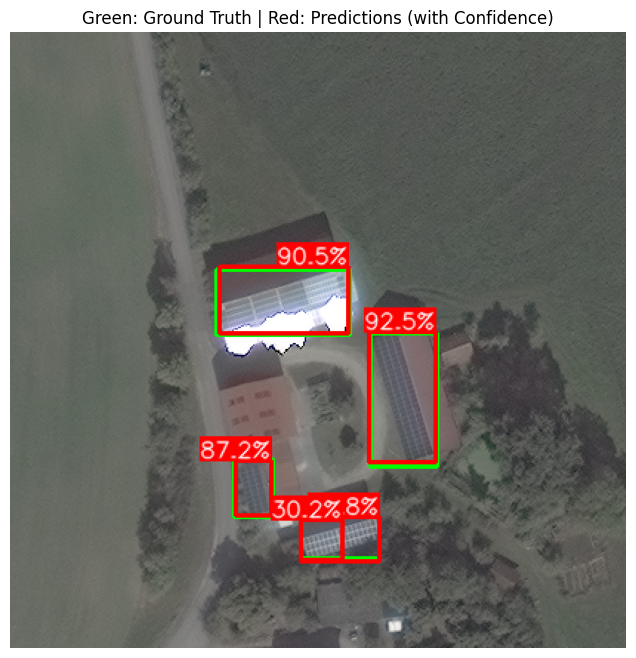


image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_3__x0_4967_y0_13867_dxdy_416.tif: 416x416 9 solar_panels, 28.0ms
Speed: 1.0ms preprocess, 28.0ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)


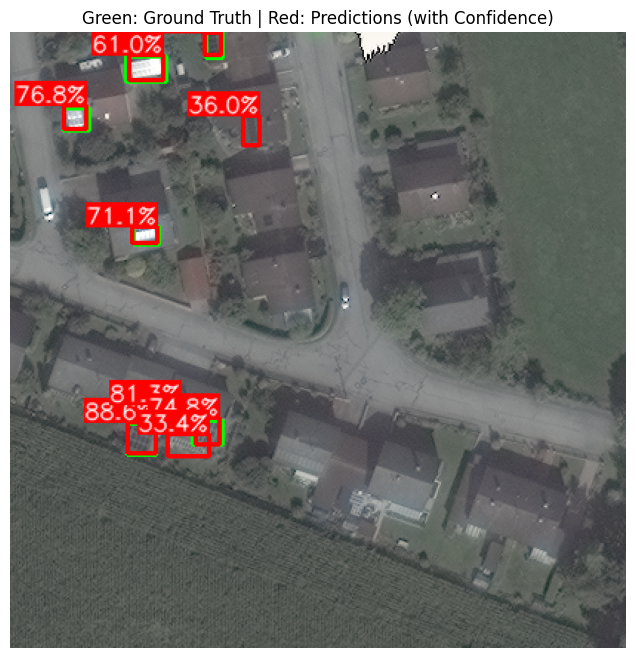


image 1/1 /kaggle/working/srip_dataset_split/test/images/solarpanels_native_3__x0_8641_y0_11799_dxdy_416.tif: 416x416 2 solar_panels, 28.0ms
Speed: 0.9ms preprocess, 28.0ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)


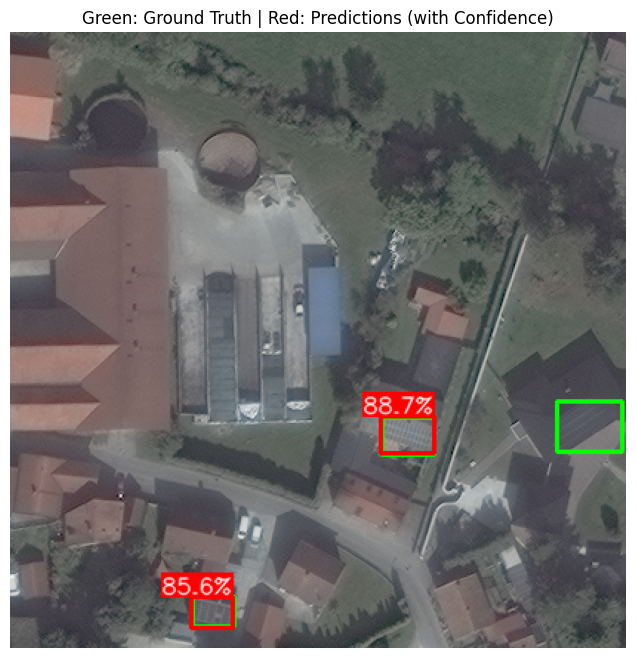

In [32]:
import os
import cv2
import glob
import random
import matplotlib.pyplot as plt
from ultralytics import YOLO

def load_gt_boxes(label_path, img_width=416, img_height=416):
    """
    Load ground truth boxes from a YOLO-format label file and convert 
    them to absolute pixel coordinates [x_min, y_min, x_max, y_max].
    
    Each line in the label file has:
        class, x_center, y_center, width, height  (all normalized)
    
    Args:
        label_path (str): Path to the label file.
        img_width (int): Image width in pixels.
        img_height (int): Image height in pixels.
    
    Returns:
        list: A list of bounding boxes in absolute coordinates.
    """
    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            # Convert the normalized values to absolute pixel coordinates
            _, x_center, y_center, w_norm, h_norm = map(float, parts)
            x_min = int((x_center - w_norm/2) * img_width)
            y_min = int((y_center - h_norm/2) * img_height)
            x_max = int((x_center + w_norm/2) * img_width)
            y_max = int((y_center + h_norm/2) * img_height)
            boxes.append([x_min, y_min, x_max, y_max])
    return boxes

# Define paths for test images and labels
test_img_dir = '/kaggle/working/srip_dataset_split/test/images'
test_lbl_dir = '/kaggle/working/srip_dataset_split/test/labels'

# Get a list of all test images (adjust extension if needed)
test_images = glob.glob(os.path.join(test_img_dir, '*'))
# Randomly sample 3-4 images for visualization
sample_images = random.sample(test_images, 4)

# Path to the trained model (run2 weights)
model_path = '/kaggle/working/srip_training/yolov11l/run2/weights/last.pt'
# Load the trained modelt
model = YOLO(model_path)

# Loop over the sample test images for prediction and visualization
for img_path in sample_images:
    # Load image using cv2 and convert to RGB for matplotlib
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Determine the corresponding label file (assuming images are .tif)
    base_name = os.path.basename(img_path)
    label_file = os.path.join(test_lbl_dir, base_name.replace('.tif', '.txt'))
    # Load ground truth boxes
    gt_boxes = load_gt_boxes(label_file, img_width=416, img_height=416)
    
    # Predict using the trained model
    results = model.predict(source=img_path, conf=0.25, iou=0.5)
    pred_boxes = []
    pred_scores = []
    
    if results:
        # Assuming results[0] contains the predictions for the image
        for box in results[0].boxes.xyxy.cpu().numpy():
            pred_boxes.append(box.tolist())
        for score in results[0].boxes.conf.cpu().numpy():
            pred_scores.append(score)
    
    # Draw ground truth boxes (green) on the image
    for box in gt_boxes:
        x_min, y_min, x_max, y_max = box
        cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    # Draw predicted boxes (red) along with confidence scores on the image
    for box, score in zip(pred_boxes, pred_scores):
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        text = f"{score*100:.1f}%"
        # Calculate text size to position the score at the top-right corner of the box
        ((text_width, text_height), _) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        # Draw a filled rectangle for better text visibility
        cv2.rectangle(img_rgb, (x_max - text_width, y_min), (x_max, y_min - text_height - 4), (255, 0, 0), -1)
        cv2.putText(img_rgb, text, (x_max - text_width, y_min - 2), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    
    # Display the image with boxes using matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.title("Green: Ground Truth | Red: Predictions (with Confidence)")
    plt.axis("off")
    plt.show()


#### 3.Use supervision.metrics functionality from supervision library to compute the following metrics.


a.Compute mAP50 with supervision and compare with your implementation. What do you observe 

In [36]:
from tqdm import tqdm
from ultralytics import YOLO
from supervision import ConfusionMatrix

In [38]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO
from supervision import mAP, ConfusionMatrix

# -------------------------------
# Helper: Load ground truth boxes
# -------------------------------

#Load ground truth boxes from a YOLO-format label file and convert them to absolute pixel coordinates [x_min, y_min, x_max, y_max].
def load_gt_boxes(label_path, img_width=416, img_height=416):

    boxes = []
    if not os.path.exists(label_path):
        return boxes
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            # YOLO format: class, x_center, y_center, width, height (all normalized)
            _, x_center, y_center, w_norm, h_norm = map(float, parts)
            x_min = int((x_center - w_norm/2) * img_width)
            y_min = int((y_center - h_norm/2) * img_height)
            x_max = int((x_center + w_norm/2) * img_width)
            y_max = int((y_center + h_norm/2) * img_height)
            boxes.append([x_min, y_min, x_max, y_max])
    return boxes

# -------------------------------
# Paths and Model Setup
# -------------------------------
test_img_dir = '/kaggle/working/srip_dataset_split/test/images'
test_lbl_dir = '/kaggle/working/srip_dataset_split/test/labels'
test_images = glob.glob(os.path.join(test_img_dir, '*'))

# Load the trained model (using run2 weights as an example)
model_path = '/kaggle/working/srip_training/yolov11l/run2/weights/best.pt'
model = YOLO(model_path)

# -------------------------------
# 1. Compute mAP50 using supervision
# -------------------------------
all_gt = []
all_pred = []

for img_path in tqdm(test_images, desc="Computing mAP50 on Test Set"):
    base_name = os.path.basename(img_path)
    label_file = os.path.join(test_lbl_dir, base_name.replace('.tif', '.txt'))
    gt_boxes = load_gt_boxes(label_file)
    for box in gt_boxes:
        all_gt.append({"image": img_path, "bbox": box, "class": 0})
    
    results = model.predict(source=img_path, conf=0.25, iou=0.5)
    for result in results:
        for box, conf in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.conf.cpu().numpy()):
            all_pred.append({
                "image": img_path,
                "bbox": box.tolist(),
                "class": 0,
                "score": float(conf)
            })

map50_sup = mAP(all_pred, all_gt, iou_threshold=0.5)
print(f"Computed mAP50 using supervision: {map50_sup:.4f}")

# If you have your own mAP50 implementation, compare here:
# map50_custom = custom_map50_function(all_pred, all_gt)
# print(f"Computed mAP50 using custom implementation: {map50_custom:.4f}")
# Observation: They should be very similar if both implementations are correct.

# -------------------------------
# 2. Compute Precision, Recall, and F1 across thresholds
# -------------------------------
iou_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
conf_thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
metrics_results = []

for iou_thresh in iou_thresholds:
    for conf_thresh in conf_thresholds:
        # Initialize ConfusionMatrix from supervision
        cm = ConfusionMatrix(class_names=['solar_panel'], 
                             iou_threshold=iou_thresh, 
                             confidence_threshold=conf_thresh)
        # Process each test image
        for img_path in test_images:
            base_name = os.path.basename(img_path)
            label_file = os.path.join(test_lbl_dir, base_name.replace('.tif', '.txt'))
            gt_boxes = load_gt_boxes(label_file)
            gt_list = [{"image": img_path, "bbox": box, "class": 0} for box in gt_boxes]
            
            # Get predictions for the current thresholds
            results = model.predict(source=img_path, conf=conf_thresh, iou=iou_thresh)
            pred_list = []
            for result in results:
                for box, conf in zip(result.boxes.xyxy.cpu().numpy(), result.boxes.conf.cpu().numpy()):
                    pred_list.append({
                        "image": img_path,
                        "bbox": box.tolist(),
                        "class": 0,
                        "score": float(conf)
                    })
            # Update the confusion matrix with predictions and ground truths for this image
            cm.process_batch(pred_list, gt_list)
        
        # Extract confusion matrix statistics
        TP = cm.TP
        FP = cm.FP
        FN = cm.FN
        precision_val = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall_val = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_val = 2 * precision_val * recall_val / (precision_val + recall_val) if (precision_val + recall_val) > 0 else 0
        
        metrics_results.append({
            "IoU Threshold": iou_thresh,
            "Confidence Threshold": conf_thresh,
            "Precision": precision_val,
            "Recall": recall_val,
            "F1": f1_val
        })

# Convert results to a DataFrame for easier visualization
df_metrics = pd.DataFrame(metrics_results)
print("\nOverall Metrics Table:")
print(df_metrics)

# Optionally, create pivot tables for each metric
pivot_precision = df_metrics.pivot(index="IoU Threshold", columns="Confidence Threshold", values="Precision")
pivot_recall    = df_metrics.pivot(index="IoU Threshold", columns="Confidence Threshold", values="Recall")
pivot_f1        = df_metrics.pivot(index="IoU Threshold", columns="Confidence Threshold", values="F1")

print("\nPivot Table for Precision:")
print(pivot_precision)
print("\nPivot Table for Recall:")
print(pivot_recall)
print("\nPivot Table for F1 Score:")
print(pivot_f1)


ImportError: cannot import name 'mAP' from 'supervision' (/usr/local/lib/python3.10/dist-packages/supervision/__init__.py)

b.Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1) 